# 0.0 Table of Contents

1. [Introduction](#1.0-Introduction)

2. [Feature Analysis](#2.0-Feature-Analysis)

# 1.0 Introduction
 

### 1.1 Project -  Binary classification of bitcoin addresses

-  **GOAL:** to predict whether an address has been the recipient of ransomware coins. 

-  **DATA:**  Data is time series (24hr chunks) derived from the topological and geometrical properties of the bitcoin network.

### 1.2 Basics

- Ransomware is a rogue compute code that encrypts the victim's filesystem unless money is paid to the attacker for decryption. 

- Bitcoin is often used for these payments because it provides a semi-anonymous transaction method.  

- The dataset was taken from the UCI Machine Learning Repository. It contains labelled data of addresses according to whether they have been involved in Ransomware. The data is from 2009 January to 2018 December. 
- Link to the data-set: [click here](https://archive.ics.uci.edu/ml/datasets/BitcoinHeistRansomwareAddressDataset)

### 1.2.0 Breakdown

---
**"starter transactions"**: transactions which are spent outputs from the  previous time window <n>

Features:

- The **address** is a public BC address which can receive and send bitcoins.        
- The **income** of an address $a$ is the total amount of coins output to it measured in Satoshis (1 millionth of a BC).
- The number of (in) **neighbors** of an address $a$  is the number of transactions which
have $a$ as one of its output addresses.
- The **weight** of an address is the sum of the fraction of *coins* that come from a starter transaction and merge at the address. Weight quantifies the merge behavior (i.e., the transaction has more input addresses than output addresses), where coins
in multiple addresses are each passed through a succession of
merging transactions and accumulated in a final address.
- The **length** of an address $a$ is the number of non-starter transactions connected to $a$ on the longest chain.  A length of zero implies that the address is the recipient of starter transaction.
- The **count** of an address $a$ is the number of starter transactions
which are connected to $a$ in a chain, where a chain is
defined as an acyclic directed path originating from a starter
transaction and ending at address $a$. Count captures
information about the number of transactions, whereas weight
 gives information about the amount of coins.
- **looped** is the number of starter transactions connected to $a$ by more than one path (chain). 
    
       
<n>
Engineered/derived features:
    
- bc_income = boxcox of income
    
- bc_length = boxcox of length
    
- yeo_weight = yeo of weight
   
- logbc_n_address = boxcox log of address

- bc_neighbors = box of neighbors
   
- sig_looped = sigmoid of looped
    
- log_count = log of count
   
- day_of_week = {'Monday':0,...,'Sunday': 6}

### 1.3 Packages and helper functions

In [1]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
from tqdm.notebook import tqdm
import pickle
import datetime
import warnings

from scipy import stats
from scipy.stats import boxcox, yeojohnson
from scipy.stats import shapiro

from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, plot_roc_curve, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
warnings.filterwarnings("ignore", category=UserWarning)
_ = np.seterr(over='ignore')
#from pretty_confusion_matrix import plot_confusion_matrix_from_data as conf_matrix
warnings.simplefilter(action='ignore', category=FutureWarning)

/Users/antares/.pyenv/versions/mambaforge-4.10.1-4/envs/ih_DA_env/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
RAND_STATE  = 42
SPLIT_RATIO = 0.23
SAVE_TEST_TRAIN = False
DS_FRAC = .12
NF = 7

### 1.4 Importing data

In [4]:
df = pd.read_csv('data/BitcoinHeistData.csv')
df = df.sample(frac=DS_FRAC, axis=0,random_state=RAND_STATE) # take a sample portion of the data

dft = df.copy()
ROWS = df.shape[0]
COLS = df.shape[1]
ROWS,COLS


(350004, 10)

In [5]:
df.head()

address  year  day  length    weight  \
2667698  15DQFhP5R7ZeaBS9Ute7NzrYVBFSH1Z2kZ  2018   82       8  1.311111   
2013400  3FhUXgmVecach9dZ59JK1yBLEcr9JsvJXZ  2016  157       2  0.025000   
2704440  3DpHZaCtj88yaXUtajYnYLb8xgN15K8fnw  2018  118     144  3.619217   
1650833  1G6doAKXpDsnsdSA1wgh7jfAnkaPi49M4y  2015  160     144  0.000484   
1586811   175gAXqbkq4nho268FZxoBZ7TCCZWzWcg  2015   96     128  0.625000   

         count  looped  neighbors       income  label  
2667698      3       0          2  577264100.0  white  
2013400     44       0          1  100000000.0  white  
2704440   5991    5991          2  299950000.0  white  
1650833   3452    3049          2  299000000.0  white  
1586811      2       0          2   40000000.0  white

In [6]:
df.label.value_counts()

white                          345060
paduaCryptoWall                  1476
montrealCryptoLocker             1144
princetonCerber                  1083
princetonLocky                    785
montrealCryptXXX                  293
montrealDMALockerv3                51
montrealNoobCrypt                  45
montrealDMALocker                  26
montrealSamSam                     11
montrealGlobe                       7
montrealCryptoTorLocker2015         5
montrealGlobeImposter               5
montrealWannaCry                    2
montrealVenusLocker                 2
montrealCryptConsole                2
montrealSam                         1
montrealFlyper                      1
montrealAPT                         1
montrealXLocker                     1
montrealEDA2                        1
montrealJigSaw                      1
montrealRazy                        1
Name: label, dtype: int64

In [7]:
# removing the prefix on some of the labels
study_origins = ["princeton","padua","montreal"] #
for r in study_origins:
    dft['label']=dft['label'].str.replace(r,"")
    df['label']=df['label'].str.replace(r,"")
del study_origins
df.label.value_counts()

white                  345060
CryptoWall               1476
CryptoLocker             1144
Cerber                   1083
Locky                     785
CryptXXX                  293
DMALockerv3                51
NoobCrypt                  45
DMALocker                  26
SamSam                     11
Globe                       7
CryptoTorLocker2015         5
GlobeImposter               5
WannaCry                    2
VenusLocker                 2
CryptConsole                2
Sam                         1
Flyper                      1
APT                         1
XLocker                     1
EDA2                        1
JigSaw                      1
Razy                        1
Name: label, dtype: int64

In [8]:
years = df['year'].unique()
print('The data extends from {} to {}.'.format(years.min(),years.max()))
print('File contains {:d} rows and {} columns'.format(df.shape[0], df.shape[1]))


The data extends from 2011 to 2018.
File contains 350004 rows and 10 columns


In [9]:
features=list(df.columns)[:-1]
print('Feature columns: \n{}'.format(features))

Feature columns: 
['address', 'year', 'day', 'length', 'weight', 'count', 'looped', 'neighbors', 'income']


In [10]:
graph_fs = ['length', 'weight', 'count', 'neighbors',
            'income']  # features relating to the topological properties of the BC network


In [11]:
print('Datatypes: \n\n{}'.format(df.dtypes))

Datatypes: 

address       object
year           int64
day            int64
length         int64
weight       float64
count          int64
looped         int64
neighbors      int64
income       float64
label         object
dtype: object


In [12]:
#top_ransomwares_dict = dict(df.label.value_counts().head(10)[1:])
# top10_ransoms_labels = df.label.value_counts()[1:11]
print('The top ransomware types are \n\n', df.label.value_counts()[1:11])

The top ransomware types are 

 CryptoWall      1476
CryptoLocker    1144
Cerber          1083
Locky            785
CryptXXX         293
DMALockerv3       51
NoobCrypt         45
DMALocker         26
SamSam            11
Globe              7
Name: label, dtype: int64


In [13]:
print('The data is over 95% unbalanced towards clean transactions!\n\nwhite label cnt: {}\nrannsomware label cnt: {}'\
      .format(df['label'].value_counts()[0], 
        sum(df['label'].value_counts()[1:])
             ))


The data is over 95% unbalanced towards clean transactions!

white label cnt: 345060
rannsomware label cnt: 4944


### 1.5 Cleaning the data

- check for corrupted, missing, or duplicated entries

In [14]:
df.isnull().any() # check for null values

address      False
year         False
day          False
length       False
weight       False
count        False
looped       False
neighbors    False
income       False
label        False
dtype: bool

In [15]:
print('The data is free of obvious null values')

The data is free of obvious null values


In [16]:
df = df.drop_duplicates() # if any

### 1.6 Exploration of top ransomware accounts

In [17]:
top_ransomwares_dict = df[df['label']!='white']['address'].value_counts().head(5).to_dict()
df[df['label']!='white']['address'].value_counts().head(5).to_dict()
top_ransomwares_l = list(top_ransomwares_dict.keys())
top_accts = [df[df['address'] == j] for j in top_ransomwares_l]
del top_ransomwares_dict,top_ransomwares_l

In [18]:
top_accts[0].describe()

year         day      length     weight        count  looped  \
count    46.000000   46.000000   46.000000  46.000000    46.000000    46.0   
mean   2013.413043  191.652174    7.739130   1.306249    43.500000     0.0   
std       0.497821  115.666036   29.558556   0.595379   213.875327     0.0   
min    2013.000000    5.000000    0.000000   0.500000     1.000000     0.0   
25%    2013.000000   92.250000    0.000000   1.000000     1.000000     0.0   
50%    2013.000000  181.000000    0.000000   1.000000     2.000000     0.0   
75%    2014.000000  303.000000    2.000000   1.500000     3.000000     0.0   
max    2014.000000  364.000000  144.000000   3.250000  1355.000000     0.0   

       neighbors        income  
count  46.000000  4.600000e+01  
mean    1.586957  2.869661e+09  
std     0.804876  3.755369e+09  
min     1.000000  5.495000e+07  
25%     1.000000  5.259881e+08  
50%     1.000000  1.605090e+09  
75%     2.000000  3.865788e+09  
max     4.000000  2.107868e+10

In [19]:
top_accts[0]['weight'].value_counts(normalize=True,bins=4)

(0.496, 1.188]    0.652174
(1.875, 2.562]    0.173913
(1.188, 1.875]    0.152174
(2.562, 3.25]     0.021739
Name: weight, dtype: float64

In [20]:
top_accts[0]['count'].value_counts(normalize=True,bins=4)

(-0.355, 339.5]     0.956522
(339.5, 678.0]      0.021739
(1016.5, 1355.0]    0.021739
(678.0, 1016.5]     0.000000
Name: count, dtype: float64

In [21]:
top_accts[0]['looped'].value_counts(normalize=True,bins=4)


(-0.0005, 0.0]       1.0
(-0.002, -0.0005]    0.0
(0.0, 0.0005]        0.0
(0.0005, 0.001]      0.0
Name: looped, dtype: float64

In [22]:
top_accts[0]['length'].value_counts(normalize=True,bins=4)

(-0.145, 36.0]    0.956522
(108.0, 144.0]    0.043478
(36.0, 72.0]      0.000000
(72.0, 108.0]     0.000000
Name: length, dtype: float64

In [23]:
top_df = top_accts[0] # CryptoWall top address
del top_accts

<AxesSubplot:xlabel='weight', ylabel='neighbors'>

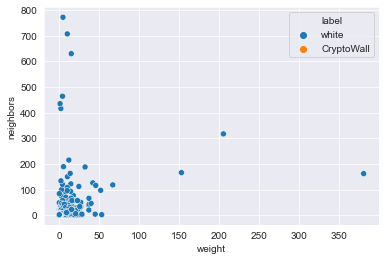

In [24]:
levels = list(top_df['label'].unique())
diver = sns.color_palette("Paired", len(levels))  # RdBu, Set3, Paired
cmap = dict(zip(levels, diver))
sns.scatterplot(x='weight', y='neighbors',
                data=df[(df['label'] == 'CryptoWall') | (df['label'] == 'white') & (df['year']== 2016)], hue='label')  #, palette=cmap)

In [25]:
del levels, diver, cmap

## 1.7 Time Series Analysis

In [26]:
def gen_n_day_col(df):
    """
    converts year+day into an integer counting days starting from the first day (time=1) and creates a new column
    :param df: data frame we add a time step col to
    :return: data frame with a new column named t_step_name "at the front" counting days from the start of the data
    """

    t_step_name = 'n_day'
    start = 2011
    year  = 365

    cols = [t_step_name]+list(df.columns) # we want to put the time id at the front of the data frame
    df[t_step_name] = ''

    for idx, _ in df.iterrows():
        off_set = (df['year'][idx]-start)*year
        df[t_step_name][idx] = df['day'][idx] + off_set

    return df[cols]

In [27]:
dft    = gen_n_day_col(dft)
top_df = gen_n_day_col(top_df)

In [28]:
dft

n_day                             address  year  day  length  \
2667698  2637  15DQFhP5R7ZeaBS9Ute7NzrYVBFSH1Z2kZ  2018   82       8   
2013400  1982  3FhUXgmVecach9dZ59JK1yBLEcr9JsvJXZ  2016  157       2   
2704440  2673  3DpHZaCtj88yaXUtajYnYLb8xgN15K8fnw  2018  118     144   
1650833  1620  1G6doAKXpDsnsdSA1wgh7jfAnkaPi49M4y  2015  160     144   
1586811  1556   175gAXqbkq4nho268FZxoBZ7TCCZWzWcg  2015   96     128   
...       ...                                 ...   ...  ...     ...   
2796843  2766  3GATJRb9VFCDRe8wQodrNvUouTWGwjLmhM  2018  211      10   
1036846  1006  18JuSPFSb4f1iWgeMenS6kFeRw2FYDX1kz  2013  276       4   
1932590  1901  1KSjpKdmpFtbLQqbhCoQ8g127AzGq8CjaY  2016   76     144   
730452    699  1A3AQAvJLVqne7ud7JT6nb3n1gkhpz7DuT  2012  334       0   
1063408  1032  1MfphSj17CXv6EkUU2siqMTUzV71DZbi2V  2013  302       0   

           weight  count  looped  neighbors        income  label  
2667698  1.311111      3       0          2  5.772641e+08  white  
2013400  0.025000     44       0          1  1.000000e+08  white  
2704440  3.619217   5991    5991          2  2.999500e+08  white  
1650833  0.000484   3452    3049          2  2.990000e+08  white  
1586811  0.625000      2       0          2  4.000000e+07  white  
...           ...    ...     ...        ...           ...    ...  
2796843  0.125000      1       0          2  2.600785e+10  white  
1036846  0.166667      1       0          2  3.012661e+08  white  
1932590  0.002160   3928    3809          2  1.213316e+08  white  
730452   1.000000      1       0          1  4.997700e+08  white  
1063408  1.000000      1       0          2  2.488927e+09  white  

[350004 rows x 11 columns]

In [29]:
t_min = dft.n_day.min()
t_max = dft.n_day.max()
n_t_folds =  int(np.floor(t_max/240))
t_max = int(np.floor(240*n_t_folds))
t_min,t_max, n_t_folds

(1, 2880, 12)

In [99]:
def split_data(df, t0):
    """
    :param df:
    :param t0: present time
    :return:
    """
    t_lag0 = 240 # earliest time will be t_present

    if t0 < t_lag0:
        print('Range Error: t_present must be grater than 480')
        return None

    lags = [240,120,60,30,0]  # f_{n+1} = f_{n}/2, f_0 = 480

    chopped_dfs = []
    for i in range(len(lags)-1):
        filter = ( df['n_day'] >= t0 - lags[i]) &  (df['n_day'] < t0 - lags[i+1])
        chopped_dfs.append(df[filter])

    return chopped_dfs

def test_train_time(X, y):
    """ takes the
    :param Xc: list of inout data frames from the last 4 windoes
    :param yc: list of lables from the last 4 windows
    :return:
    """
    lags = [240,120,60,30,0]

    X_train = {}
    X_test  = {}
    Y_train = {}
    y_test  = {}

    t_first = t0 - lags[0]
    t_min_train = t_first

    for i in range(len(lags)-1):

        t_last      = t0 - lags[i+1]
        t_max_train = t_first - 0.80 * (t_last - t_first)
        t_min_test  = t_max_train + 1
        t_max_test  = t_last - 1

        train_filter = (X['n_day'] >= t_min_train) & (X['n_day'] < t_max_train) # get indices
        test_filter  = (X['n_day'] >= t_min_test)  & (X['n_day'] < t_max_test)

        X_train[i] = X[train_filter]
        X_test[i]  = X[test_filter]

        y_train[i] = y[train_filter]
        y_test[i]  = y[test_filter]

    return X_train, y_train, X_test, y_test





In [100]:
t0 = 2450

In [101]:
chopped_dfs = split_data(dft,t0=t0)
chopped_dfs[3]['n_day'].min()

2420

In [41]:
chopped_dfs[0]

n_day                             address  year  day  length  \
2265864  2235  1JYbXc8ULh3opSL2NimX2vQEhCFgQFQ8kS  2017   45       4   
2253207  2222  1HocteMqu15255SDXsdT6HfBqNaKgjbih6  2017   32      20   
2289573  2258  1FSSVqbDPwBrE4qrwqhJq3wucoiXwj7e2X  2017   68       0   
2272067  2241  3JDir1ZMB176HTNQAvnHMp71cUHq5DhQTj  2017   51       8   
2339882  2309  3965uc4ZVxQ3MMQVYyHSCXypT6HobDxq4y  2017  119       0   
...       ...                                 ...   ...  ...     ...   
2257268  2226  14zgQi8ymTDUVfFnQMnd63Bi3iQRRLcnWq  2017   36       0   
2316823  2286  1FoTK5rxEP3ehYAKU1p8XSBB8XL9qzzuRz  2017   96     144   
2358834  2328  15ebvLRAJCsCJGM1pFbKoxPyessBsFw2H5  2017  138       0   
2291070  2260  3PZWQepCrZkQU4TrMNHC7BwzqapSQK5Yv8  2017   70       4   
2293767  2263  3Js9vpJQmasCHqwWLoZt6wsW29yFSvd4cw  2017   73       0   

           weight  count  looped  neighbors       income  label  
2265864  0.250000      1       0          2   85812500.0  white  
2253207  0.023438      2       0          1   50437060.0  white  
2289573  0.500000      1       0          1   94860000.0  white  
2272067  0.003307      4       0          2   67061348.0  white  
2339882  1.000000      1       0          2  971625106.0  white  
...           ...    ...     ...        ...          ...    ...  
2257268  0.500000      1       0          2  101095310.0  white  
2316823  0.047629   2833       0          2  100000000.0  white  
2358834  1.000000      1       0          1   39942484.0  white  
2291070  0.500000      2       0          2   50374865.0  white  
2293767  0.125000      1       0          2   55850000.0  white  

[14820 rows x 11 columns]

In [34]:
 lags = [240,120,60,30,0]
t_max_train = (t0-lags[1])*.8
t_min_train = (t0-lags[0])

In [35]:
dft[dft['n_day']==t_min_train]

n_day                             address  year  day  length  \
2241506  2210  19ZzJaANvWmvXaUGKtHX8BLM1cFBtHJ89A  2017   20     144   
2241521  2210  1B9iNh9JLsC7gv2RRvbKYQHNmjTKuHESum  2017   20       0   
2240714  2210  1D1szSfxj6j8amzuhBKDAmiPf9wEZbe8fi  2017   20     144   
2241456  2210  3K7waPaM2SkQoZevDXsqi742MS5Sx8aA6e  2017   20     144   
2240962  2210  14tPTjXjAtRiRu8gfxrWygZGwxzNVYcSSD  2017   20      14   
...       ...                                 ...   ...  ...     ...   
2241092  2210  3KGaTiqKa4hs8cxrMfzRsZzLV73DLdDU4V  2017   20       4   
2241618  2210  1NqjHHEg3hBupqxEePeKk85WyedZz9y11U  2017   20       4   
2241155  2210  1Cvfy4XjukTMSNRwQKSZRxdazWbGar7DC7  2017   20       2   
2241267  2210  153SDqL8r7LRMAEuKmM2UVHM2GBM2X4gj9  2017   20       0   
2241547  2210  382GHdFCPT79G9afzyRz4gsZNco7hVhXxz  2017   20       4   

           weight  count  looped  neighbors        income  label  
2241506  0.405547   1042       0          2  4.383773e+08  white  
2241521  1.000000      1       0          1  2.000000e+08  white  
2240714  0.126512   2466       0          2  5.683581e+08  white  
2241456  0.325584   5450       0          2  1.540400e+09  white  
2240962  0.500000      1       0          2  1.216539e+08  white  
...           ...    ...     ...        ...           ...    ...  
2241092  0.125000      1       0          2  1.579000e+08  white  
2241618  0.031250      1       0          1  8.436124e+07  white  
2241155  0.000456      1       0          1  6.390708e+07  white  
2241267  1.000000      1       0          2  6.712514e+07  white  
2241547  0.006944      3       0          1  6.288000e+07  white  

[119 rows x 11 columns]

In [36]:
dft[dft['n_day']==t_max_train].index.value_counts().sum()

122

In [ ]:
dft[dft['n_day']==t_max_train].index.sort_values()[0]

In [31]:
#dfc=pd.concat([dfc,pd.DataFrame(pd.to_datetime(dfc['year'] * 1000 + dfc['day'], format='%Y%j'),columns=['date'])],axis=1)

In [32]:
#top_df.drop(['day', 'year'], axis=1, inplace=True)

In [245]:
top_df.sort_values(by=['n_day'], ascending=True,inplace=True)
top_df

n_day                             address  year  day  length    weight  \
34065   822  1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU  2013   92       4  1.000000   
34070   846  1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU  2013  116       0  1.000000   
34368   889  1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU  2013  159       0  1.000000   
34315   891  1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU  2013  161       0  1.000000   
34242   919  1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU  2013  189       4  3.250000   
34166   927  1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU  2013  197       0  1.000000   
34203   934  1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU  2013  204      20  0.756836   
34361   935  1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU  2013  205       0  1.000000   
34345   936  1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU  2013  206       0  1.000000   
33976   983  1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU  2013  253       2  1.000000   
33979   989  1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU  2013  259       0  1.500000   
34086   990  1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU  2013  260       0  1.000000   
34284  1008  1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU  2013  278       0  1.000000   
33970  1027  1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU  2013  297       4  1.062500   
34094  1030  1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU  2013  300       0  1.000000   
34279  1034  1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU  2013  304       2  1.514925   
34016  1040  1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU  2013  310       2  2.000000   
34181  1054  1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU  2013  324       2  2.500000   
34381  1058  1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU  2013  328     144  1.003193   
34144  1061  1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU  2013  331       2  1.000000   
34245  1072  1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU  2013  342       0  1.000000   
33971  1076  1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU  2013  346       8  0.750000   
34202  1078  1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU  2013  348       0  1.000000   
34250  1080  1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU  2013  350       0  2.000000   
34239  1092  1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU  2013  362     144  2.500000   
34276  1093  1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU  2013  363       0  1.000000   
34298  1094  1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU  2013  364       4  0.500000   
34170  1100  1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU  2014    5       0  1.000000   
34100  1101  1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU  2014    6       0  2.000000   
34373  1115  1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU  2014   20       2  1.500000   
34339  1125  1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU  2014   30       6  1.250000   
34211  1128  1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU  2014   33       2  0.500000   
34129  1142  1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU  2014   47       0  1.000000   
34232  1151  1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU  2014   56       0  1.000000   
34026  1165  1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU  2014   70       0  1.500000   
34102  1175  1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU  2014   80       0  1.500000   
33990  1176  1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU  2014   81       0  2.500000   
34186  1181  1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU  2014   86       0  1.000000   
34351  1188  1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU  2014   93       0  2.000000   
33967  1192  1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU  2014   97       0  1.500000   
34266  1212  1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU  2014  117       0  1.000000   
34121  1223  1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU  2014  128       0  2.500000   
34234  1237  1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU  2014  142       2  1.000000   
34201  1244  1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU  2014  149       0  1.000000   
34075  1250  1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU  2014  155       0  1.000000   
34184  1268  1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU  2014  173       2  1.000000   

       count  looped  neighbors        income         label  
34065      2       0          1  6.760220e+09  CryptoLocker  
34070      1       0          1  3.799540e+09  CryptoLocker  
34368      1       0          1  3.407980e+09  CryptoLocker

In [246]:
dft['n_day'].value_counts(),len(dft['n_day']) # we see that tn is not unique

(1195    169
 1025    165
 1180    164
 1061    163
 1720    162
        ... 
 1        57
 6        56
 4        52
 3        47
 2        39
 Name: n_day, Length: 2885, dtype: int64,
 350004)

In [248]:
dft[ (dft['year']==2013)& (dft['label']!='white')].groupby('n_day',sort=True).mean()

year    day     length    weight       count    looped  neighbors  \
n_day                                                                        
732    2013.0    2.0   2.000000  0.166667    1.000000  0.000000        2.0   
733    2013.0    3.0  80.000000  0.003906  784.000000  0.000000        1.0   
734    2013.0    4.0  26.000000  0.007812    1.000000  0.000000        1.0   
738    2013.0    8.0   6.000000  0.333333    1.000000  0.000000        2.0   
740    2013.0   10.0   2.000000  0.012887   23.000000  0.000000        2.0   
...       ...    ...        ...       ...         ...       ...        ...   
1090   2013.0  360.0  57.333333  1.465438    9.000000  7.666667        4.0   
1092   2013.0  362.0  72.000000  1.750000  278.500000  0.000000        2.0   
1093   2013.0  363.0   0.000000  1.000000    1.000000  0.000000        1.0   
1094   2013.0  364.0  97.333333  0.888085  601.333333  0.333333        1.0   
1095   2013.0  365.0   4.000000  0.375000    1.000000  0.000000        1.5   

             income  
n_day                
732    3.667918e+07  
733    4.801211e+08  
734    9.692008e+08  
738    9.043738e+08  
740    3.000000e+07  
...             ...  
1090   8.061151e+08  
1092   7.378050e+08  
1093   1.655000e+08  
1094   3.276633e+08  
1095   8.000000e+07  

[257 rows x 8 columns]

In [249]:
dft[(dft['year']==2013) &(dft['label']!='white')].label.value_counts().sum()

927

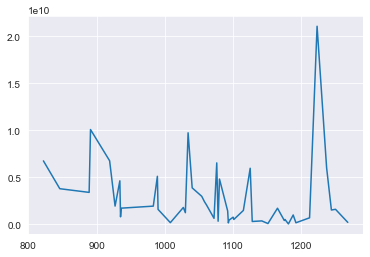

In [250]:
plt.plot(top_df['n_day'],top_df['income'])

In [251]:
np.std(top_df['count']),np.mean(top_df['count'])

(211.53782167735395, 43.5)

In [252]:
t_max/240.

12.0

In [253]:
df.year.value_counts()

2016    45328
2014    45210
2013    44780
2017    44516
2015    44011
2012    43746
2011    42704
2018    39709
Name: year, dtype: int64

In [254]:
dft[(dft['year']==2012) | (dft['year']==2011)].label.value_counts(normalize=True)

white           0.999017
CryptoLocker    0.000983
Name: label, dtype: float64

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

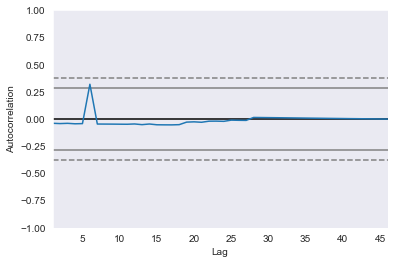

In [255]:
pd.plotting.autocorrelation_plot(top_df['count'])  # is there some periodicity in the signal?

In [256]:
top_df['income'].autocorr(lag=20)

0.30429882731934177

In [257]:
year_vars = df.groupby('year').mean()

In [258]:
df[df['year']==2018]['label'].value_counts()

white    39709
Name: label, dtype: int64

In [259]:
mean_white_per_yr = df[df['label'] == 'white'].groupby('year').mean()
mean_red_per_yr = df[df['label'] != 'white'].groupby('year').mean()

In [260]:
mean_white_per_yr

day     length    weight        count      looped  neighbors  \
year                                                                        
2011  188.590047  22.820656  0.370436    11.857728    1.292881   1.751101   
2012  182.767022  25.489981  0.571985   150.749983   39.022329   2.621550   
2013  183.112581  29.919321  0.644356   277.741637   65.123275   2.416437   
2014  183.039453  64.812625  0.448605   589.879480  371.427301   2.056963   
2015  182.170395  71.347238  0.471931  1136.234368  609.239600   2.176292   
2016  183.778435  50.415058  0.588719  1041.226075  299.894291   2.187004   
2017  183.175556  46.290999  0.561547  1183.833194  236.154589   1.998980   
2018  165.800045  48.287492  0.729389  1409.337102  298.261427   2.659976   

            income  
year                
2011  1.185503e+10  
2012  9.685239e+09  
2013  4.322880e+09  
2014  1.400012e+09  
2015  1.838177e+09  
2016  1.921585e+09  
2017  1.764899e+09  
2018  1.764085e+09

In [261]:
mean_red_per_yr

day     length    weight       count      looped  neighbors  \
year                                                                       
2011  320.000000  15.500000  0.196121   10.500000    0.000000   2.000000   
2012  216.617284  15.506173  0.236797    4.456790    1.876543   2.086420   
2013  271.145631  31.167206  0.914165  288.636462   87.786408   3.093851   
2014  111.820908  47.761750  0.904739  363.008104  145.828201   2.223663   
2015  197.976744  46.251163  0.421121  614.941860   65.627907   1.369767   
2016  181.699304  46.268593  0.360525  877.061530   70.626538   1.682718   
2017   83.619048  37.413534  0.265526  793.383459   32.744361   1.937343   

            income  
year                
2011  1.119131e+08  
2012  6.246729e+08  
2013  2.384922e+09  
2014  8.338022e+08  
2015  2.827447e+08  
2016  1.996756e+08  
2017  1.626718e+08

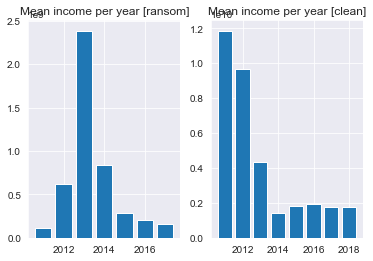

In [262]:
yrs = list(mean_red_per_yr['income'].index)
yrs
fig, ax = plt.subplots(1,2)
ax[0].set_title('Mean income per year [ransom]')
#plt.xlabel('year')
ax[0].bar(yrs,mean_red_per_yr['income'])
yrs.append(2018)
ax[1].set_title('Mean income per year [clean]')
ax[1].bar(yrs,mean_white_per_yr['income'])
del yrs, fig, ax

In [263]:
del yrs

NameError: name 'yrs' is not defined

### 1.7 X,y split

In [139]:
def labels_to_binary(df_labels):
    """ converts ransomware labels to binary. white labels are zero and dirty labels are one.
    :param df_labels: labels column in the data
    :return: transformed binary labels
    """
    # joins the classes of ransomware labels and into 'detected'=1, 'not detected'=0


    labels = pd.DataFrame([],columns=["labels"])

    for idx, label in df_labels.iteritems():
        print(idx,label)
        if label == 'white':
            labels.loc[idx] = 0
        else:
            labels.loc[idx] = 1
    return labels


In [142]:
labels = labels_to_binary(dft.label) # recast labels into binary

2667698 white
2013400 white
2704440 white
1650833 white
1586811 white
2265864 white
192439 white
651127 white
1708494 white
1003867 white
647971 white
2385528 white
1742678 white
1257283 white
1791220 white
536873 white
2362033 white
1165980 white
2135221 white
2505628 white
146555 white
2448188 white
1935893 white
2253207 white
631237 white
127791 white
221643 white
1689441 white
2229314 white
1284696 white
1387341 white
2480865 white
815271 white
1593056 white
860295 white
1426338 white
527713 white
412338 white
1876734 white
1907611 white
2289573 white
348609 white
2519513 white
1926793 white
1568989 white
2757123 white
1213023 white
1369112 white
1980917 white
504756 white
1475835 white
1636273 white
335528 white
1885311 white
2563542 white
2912187 white
2665941 white
1950368 white
1180185 white
1459690 white
792894 white
1032915 white
1581383 white
1684521 white
2453764 white
2411433 white
3898 CryptoWall
146832 white
2122314 white
1930362 white
2076084 white
1795909 white
2272067

In [146]:
labels

labels
2667698       0
2013400       0
2704440       0
1650833       0
1586811       0
...         ...
2796843       0
1036846       0
1932590       0
730452        0
1063408       0

[350004 rows x 1 columns]

In [147]:
labels_df = pd.DataFrame(labels,columns=['labels'])

In [148]:
labels_df

labels
2667698       0
2013400       0
2704440       0
1650833       0
1586811       0
...         ...
2796843       0
1036846       0
1932590       0
730452        0
1063408       0

[350004 rows x 1 columns]

In [47]:
print('Percentage of labels \
belonging to ransomware class: {:.2}'.format( (sum(labels) / len(labels)) * 100) )

Percentage of labels belonging to ransomware class: 1.4


**Defining {X, X_test, x_rain, y_test, y_train}**

In [48]:
X_df = dft.drop(['label'],axis=1) # X=features [original]
X = X_df.to_numpy()

In [54]:
labels_df = labels_df.astype(int)
y_df = labels_df

In [116]:
X_train, X_test, y_train, y_test = test_train_time(X_df, labels_df)

IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

In [58]:
# WORKING test train split. We perform many operations on this data
# We will down sample this data for plotting, testing, and training optimization
X_train, X_test, y_train, y_test = train_test_split(
    X_df,                        # design matrix
    labels_df,                   # y
    stratify = labels,           #  stratify preserves the large imbalance in the target variable
    random_state = RAND_STATE,
    test_size = SPLIT_RATIO
)

In [69]:
filter

Empty DataFrame
Columns: [n_day, address, year, day, length, weight, count, looped, neighbors, income]
Index: []

In [91]:
t0=1234
t0 - 240 + 0.80 * (t0 -240 - t0 + 120)

898.0

In [92]:
t0-240

994

In [109]:
filter = (X_df['n_day']  >  t0 - 240) & (X_df['n_day'] <  t0 - 240 + 0.80 * (t0 +240 - t0 - 120))
filter

2667698    False
2013400    False
2704440    False
1650833    False
1586811    False
           ...  
2796843    False
1036846    False
1932590    False
730452     False
1063408    False
Name: n_day, Length: 350004, dtype: bool

In [110]:
filter.value_counts()

False    338268
True      11736
Name: n_day, dtype: int64

In [111]:
X_df[filter]

n_day                             address  year  day  length  \
2265864  2235  1JYbXc8ULh3opSL2NimX2vQEhCFgQFQ8kS  2017   45       4   
2253207  2222  1HocteMqu15255SDXsdT6HfBqNaKgjbih6  2017   32      20   
2289573  2258  1FSSVqbDPwBrE4qrwqhJq3wucoiXwj7e2X  2017   68       0   
2272067  2241  3JDir1ZMB176HTNQAvnHMp71cUHq5DhQTj  2017   51       8   
2276668  2245  1JtNYNnGedWenXsH2aa8hF34TY5DGwsTce  2017   55      38   
...       ...                                 ...   ...  ...     ...   
2303207  2272  157ahbqyJ8k1UYDNat8ZS3Hq2hAvp3KfvY  2017   82       0   
2257268  2226  14zgQi8ymTDUVfFnQMnd63Bi3iQRRLcnWq  2017   36       0   
2316823  2286  1FoTK5rxEP3ehYAKU1p8XSBB8XL9qzzuRz  2017   96     144   
2291070  2260  3PZWQepCrZkQU4TrMNHC7BwzqapSQK5Yv8  2017   70       4   
2293767  2263  3Js9vpJQmasCHqwWLoZt6wsW29yFSvd4cw  2017   73       0   

           weight  count  looped  neighbors       income  
2265864  0.250000      1       0          2   85812500.0  
2253207  0.023438      2       0          1   50437060.0  
2289573  0.500000      1       0          1   94860000.0  
2272067  0.003307      4       0          2   67061348.0  
2276668  0.001953      1       0          1  593384858.0  
...           ...    ...     ...        ...          ...  
2303207  1.000000      1       0          1  683224789.0  
2257268  0.500000      1       0          2  101095310.0  
2316823  0.047629   2833       0          2  100000000.0  
2291070  0.500000      2       0          2   50374865.0  
2293767  0.125000      1       0          2   55850000.0  

[11736 rows x 10 columns]

In [118]:
X_df

n_day                             address  year  day  length  \
2667698  2637  15DQFhP5R7ZeaBS9Ute7NzrYVBFSH1Z2kZ  2018   82       8   
2013400  1982  3FhUXgmVecach9dZ59JK1yBLEcr9JsvJXZ  2016  157       2   
2704440  2673  3DpHZaCtj88yaXUtajYnYLb8xgN15K8fnw  2018  118     144   
1650833  1620  1G6doAKXpDsnsdSA1wgh7jfAnkaPi49M4y  2015  160     144   
1586811  1556   175gAXqbkq4nho268FZxoBZ7TCCZWzWcg  2015   96     128   
...       ...                                 ...   ...  ...     ...   
2796843  2766  3GATJRb9VFCDRe8wQodrNvUouTWGwjLmhM  2018  211      10   
1036846  1006  18JuSPFSb4f1iWgeMenS6kFeRw2FYDX1kz  2013  276       4   
1932590  1901  1KSjpKdmpFtbLQqbhCoQ8g127AzGq8CjaY  2016   76     144   
730452    699  1A3AQAvJLVqne7ud7JT6nb3n1gkhpz7DuT  2012  334       0   
1063408  1032  1MfphSj17CXv6EkUU2siqMTUzV71DZbi2V  2013  302       0   

           weight  count  looped  neighbors        income  
2667698  1.311111      3       0          2  5.772641e+08  
2013400  0.025000     44       0          1  1.000000e+08  
2704440  3.619217   5991    5991          2  2.999500e+08  
1650833  0.000484   3452    3049          2  2.990000e+08  
1586811  0.625000      2       0          2  4.000000e+07  
...           ...    ...     ...        ...           ...  
2796843  0.125000      1       0          2  2.600785e+10  
1036846  0.166667      1       0          2  3.012661e+08  
1932590  0.002160   3928    3809          2  1.213316e+08  
730452   1.000000      1       0          1  4.997700e+08  
1063408  1.000000      1       0          2  2.488927e+09  

[350004 rows x 10 columns]

In [125]:
X_train.sort_values(by='tn')

tn                             address  year  day  length  \
41866       1  1Nred55izjVR6fVYh7cZ2JzT6VgjTom1Gp  2011    1      32   
41576       1  1BPw9qg7H7YptnKJuMRWmMgiLFM2HeNYGo  2011    1      34   
41561       1  13BJvLGAByQxPQacwiuPSPKxYM6Eedp85C  2011    1      42   
41679       1  1Mzb8VZuSUzBmcEs8sYQMyCGT669qXm7w6  2011    1      14   
41731       1  1E2cm87Rchz7PxUy199KKFCJLHxqWQtdYB  2011    1      84   
...       ...                                 ...   ...  ...     ...   
2916545  2885  3Mcu6Se4oqBSnKEyxNRPcLDomL9gQxBLML  2018  330     144   
2916056  2885  3MNfySAgK46rhdNmbUWoGnyXUzkc5HMRgQ  2018  330     144   
2916363  2885  3QW8aZn52TH59rKQ1aAL7V1VQLbTKu7Sob  2018  330       6   
2916422  2885  1PPHgVfQDDGTB6irQpCoC7RU2zSog2Px1t  2018  330       0   
2916303  2885  1AZxR5te7rkJW7mRG23BdrSxpoZdXMQhAk  2018  330      68   

           weight  count  looped  neighbors        income  
41866    0.000122      1       0          2  1.479000e+09  
41576    1.000000      1       0          2  1.266600e+10  
41561    0.000008      1       0          2  9.930000e+08  
41679    0.162310     20       0          2  6.000000e+07  
41731    1.000000      1       0          2  1.254100e+10  
...           ...    ...     ...        ...           ...  
2916545  0.125456   7640       0          2  6.180000e+07  
2916056  0.422602   8184    6038          2  9.157144e+07  
2916363  0.125000      1       0          2  1.344188e+08  
2916422  0.500000      1       0          2  3.242362e+08  
2916303  1.000000      1       0          2  6.566600e+07  

[269503 rows x 10 columns]

In [127]:
#if SAVE_TEST_TRAIN == True:
#    with open('X_train_y_train_X_test_y_test_label_v3_01.pickle', 'wb') as save_file:
#        pickle.dump([X_train, y_train, X_test, y_test], save_file)

if SAVE_TEST_TRAIN == True:
    fname = 'X_train_y_train_X_test_y_test_v2_0'+str(NF)+'.pickle'
    with open(fname, 'wb') as save_file:
        pickle.dump([X_train, y_train, X_test, y_test], save_file)

# 2.0 Feature Analysis

* Transform features to reduce their skew
* Normalize to unit variance and zero mean for distance classification
* Engineer new features from the old ones

In [251]:
pt = PowerTransformer(method='box-cox') # transformer to reduce skew, not standard

In [252]:
def plot_box(col_var):
        return sns.boxplot(x=col_var)
def plot_pdf(col_var, title=''):
        # plots distributions

        #self.col = s.name
        sns.distplot(col_var, color="c")
        plt.title(title +  ' distribution')
        plt.ylabel('$\pho')
        plt.xlabel(col_var.name)
        plt.plot()

In [253]:
class Feature:
    def __init__(self, df, colname):
        self.df = df
        self.col = colname
        self.vec = np.array(self.df[self.col])
        self.series = self.df[self.col]
        if self.series.dtype == 'O':
            pass
        else:
            self.skew = self.series.skew()
            self.mean = self.series.mean()
            self.var  = self.series.var()
            self.std  = self.series.std()
    def plot_pdf(self):
        # plots distributions
        sns.distplot(self.series, color="c")
        plt.title(str(self.col) +  ' distribution')
        plt.ylabel('density')
        plt.xlabel(self.col)
        plt.plot()
    def plot_box(self):
        return sns.boxplot(x=self.series)
    def apply_pt_for_plots(self):
        return pt.fit_transform(self.vec.reshape(-1,1))
    def bc(self):
        # boxcox on column
        return  boxcox(self.series)[0] 
    def yeo(self):   
        # yeo on column
        return  yeojohnson(self.series)[0] 
    def sigmoid(self):
        # logistic function
        return 1 / (1 + np.exp(-self.vec))

In [254]:
train_features = {
    "address": Feature(X_train,'address'),
    "income": Feature(X_train,'income'),
    "day": Feature(X_train, 'day'),
    "year": Feature(X_train,'year'),
    "length": Feature(X_train, 'length'),
    "weight": Feature(X_train, 'weight'),
    "neighbors": Feature(X_train,'neighbors'),
    "count": Feature(X_train,'count'),
    "looped": Feature(X_train,'looped')}

test_features = {
    "address": Feature(X_test,'address'),
    "income": Feature(X_test,'income'),
    "day": Feature(X_test, 'day'),
    "year": Feature(X_test,'year'),
    "length": Feature(X_test, 'length'),
    "weight": Feature(X_test, 'weight'),
    "neighbors": Feature(X_test,'neighbors'),
    "count": Feature(X_test,'count'),
    "looped": Feature(X_test,'looped')}

In [255]:
train_features_d = {} # derived through transformations to be more normally distributed and on smaller domains
test_features_d = {}

train_features_d['year'] = Feature(X_train,'year')
test_features_d['year']  = Feature(X_test,'year')

In [151]:
# statistics of the graph properties
df[df['label']!='white'].groupby('label')[graph_fs].describe()

length                                               \
                      count        mean         std    min    25%    50%   
label                                                                      
APT                     1.0    2.000000         NaN    2.0    2.0    2.0   
Cerber               1083.0   42.035088   57.243543    0.0    2.0    8.0   
CryptConsole            2.0   72.000000  101.823376    0.0   36.0   72.0   
CryptXXX              293.0   48.648464   58.101493    0.0    2.0   16.0   
CryptoLocker         1144.0   30.968531   50.384965    0.0    0.0    6.0   
CryptoTorLocker2015     5.0   32.400000   62.424354    2.0    4.0    4.0   
CryptoWall           1476.0   48.891599   62.199693    0.0    2.0    8.0   
DMALocker              26.0   19.384615   46.150256    0.0    0.0    2.0   
DMALockerv3            51.0   44.666667   63.618446    0.0    0.0    4.0   
EDA2                    1.0  144.000000         NaN  144.0  144.0  144.0   
Flyper                  1.0   14.000000         NaN   14.0   14.0   14.0   
Globe                   7.0   43.714286   68.599597    0.0    1.0    6.0   
GlobeImposter           5.0   33.600000   62.119240    0.0    2.0    4.0   
JigSaw                  1.0    0.000000         NaN    0.0    0.0    0.0   
Locky                 785.0   47.329936   61.892966    0.0    2.0    8.0   
NoobCrypt              45.0   26.844444   55.193031    0.0    0.0    0.0   
Razy                    1.0   54.000000         NaN   54.0   54.0   54.0   
Sam                     1.0    6.000000         NaN    6.0    6.0    6.0   
SamSam                 11.0   43.454545   64.851158    0.0    0.0    8.0   
VenusLocker             2.0    8.000000    2.828427    6.0    7.0    8.0   
WannaCry                2.0  144.000000    0.000000  144.0  144.0  144.0   
XLocker                 1.0  144.000000         NaN  144.0  144.0  144.0   

                                   weight             ... neighbors        \
                       75%    max   count       mean  ...       75%   max   
label                                                 ...                   
APT                    2.0    2.0     1.0   1.500000  ...       2.0   2.0   
Cerber                72.0  144.0  1083.0   0.296815  ...       2.0  10.0   
CryptConsole         108.0  144.0     2.0   0.708110  ...       2.0   2.0   
CryptXXX             102.0  144.0   293.0   0.352714  ...       2.0   6.0   
CryptoLocker          28.0  144.0  1144.0   0.840725  ...       3.0  63.0   
CryptoTorLocker2015    8.0  144.0     5.0   0.986878  ...      11.0  16.0   
CryptoWall           144.0  144.0  1476.0   0.767319  ...       2.0  37.0   
DMALocker              6.0  144.0    26.0   0.917706  ...       2.0   6.0   
DMALockerv3          144.0  144.0    51.0   0.530395  ...       1.0   4.0   
EDA2                 144.0  144.0     1.0   0.000303  ...       2.0   2.0   
Flyper                14.0   14.0     1.0   0.500000  ...       2.0   2.0   
Globe                 77.0  144.0     7.0   0.338471  ...       2.0   3.0   
GlobeImposter         18.0  144.0     5.0   0.643282  ...       5.0   9.0   
JigSaw                 0.0    0.0     1.0   0.111111  ...       2.0   2.0   
Locky                144.0  144.0   785.0   0.374995  ...       1.0   6.0   
NoobCrypt              8.0  144.0    45.0   0.732404  ...       1.0   2.0   
Razy                  54.0   54.0     1.0  26.411461  ...      27.0  27.0   
Sam                    6.0    6.0     1.0   0.062500  ...       3.0   3.0   
SamSam                81.0  144.0    11.0   0.570040  ...       2.0   4.0   
VenusLocker            9.0   10.0     2.0   0.041667  ...       2.0   2.0   
WannaCry             144.0  144.0     2.0   0.007810  ...       1.0   1.0   
XLocker              144.0  144.0     1.0   0.412207  ...       1.0   1.0   

                     income                                            \
                      count          mean           std           min   
label                                           

In [148]:
# statistics of the graph properties
dft[dft['label']=='white'].groupby('label')[graph_fs].describe()

length                                                       weight  \
          count       mean        std  min  25%  50%    75%    max     count   
label                                                                          
white  345060.0  44.947992  58.935955  0.0  2.0  8.0  106.0  144.0  345060.0   

                 ... neighbors             income                              \
           mean  ...       75%      max     count          mean           std   
label            ...                                                            
white  0.546767  ...       2.0  12920.0  345060.0  4.323266e+09  1.557013e+11   

                                                                        
              min          25%          50%          75%           max  
label                                                                   
white  30000000.0  73504278.25  200000000.0  999950000.0  4.966515e+13  

[1 rows x 40 columns]

#### 2.1.0 income [bc_income]

In [256]:
train_features['income'].series.describe()

count    5.614630e+05
mean     4.272640e+09
std      1.453427e+11
min      3.000000e+07
25%      7.408249e+07
50%      1.999900e+08
75%      9.941911e+08
max      4.966515e+13
Name: income, dtype: float64

In [462]:
train_features['income'].series.value_counts(bins=5)

(-49635122076.175, 9933054415234.8]       561456
(39732127660939.2, 49665152076174.0]           4
(9933054415234.8, 19866078830469.6]            2
(19866078830469.6, 29799103245704.402]         1
(29799103245704.402, 39732127660939.2]         0
Name: income, dtype: int64

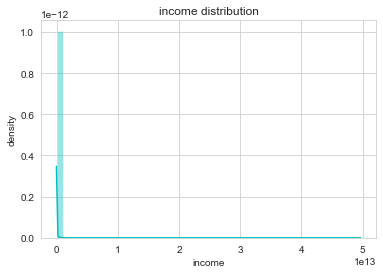

In [257]:
train_features['income'].plot_pdf()

The Shapiro–Wilk test tests the null hypothesis that a sample x1, ..., xn came from a normally distributed population.

In [489]:
#shapiro(train_features['income'].series)
shapiro(X_train['income'])

stats.anderson(X_train.income, dist='norm')

AndersonResult(statistic=205270.3457565758, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

In [258]:
print('Income skew = {}'.format(train_features['income'].skew)) # highly skwewed

Income skew = 250.7389157110026


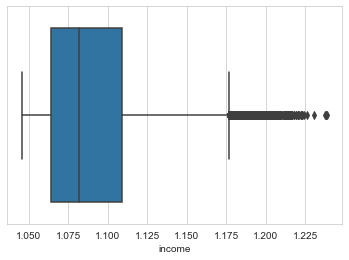

In [259]:
# reducing skew with log
log_inc = np.log(np.log(np.log(X_train['income'])))
ax = plot_box(log_inc)

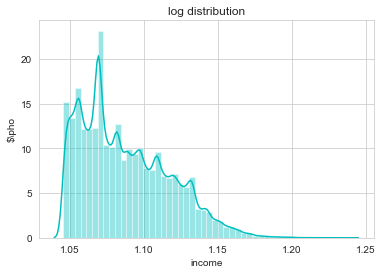

In [260]:
plot_pdf(log_inc, 'log')

Log doesn't quite normalize the distribution. Try with boxcox

In [261]:
# boxcox 
bc_income_train = train_features['income'].bc() # np array
bc_income_test = test_features['income'].bc()   # np array

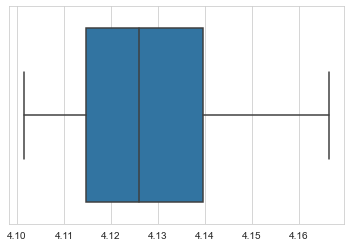

In [262]:
ax = plot_box(bc_income_train) # box plot of boxcox(income)

Applying the box-cox transform has removed the outliers

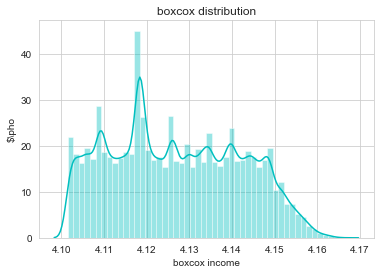

In [263]:
plot_pdf(pd.Series(bc_income_train, name='boxcox income'), 'boxcox')

In [264]:
# Seems good enough to save as a new engineered feature
train_features_d['bc_income'] = Feature(pd.DataFrame(bc_income_train, columns=['bc_income']),'bc_income')
test_features_d['bc_income']  = Feature(pd.DataFrame(bc_income_test, columns=['bc_income']),'bc_income')

In [265]:
train_features_d['bc_income'].skew

0.15785959251757625

In [479]:
shapiro(test_features_d['bc_income'].series)


ShapiroResult(statistic=0.8034206628799438, pvalue=0.0)

#### 2.1.1 day [day_of_week]

In [272]:
train_features['day'].series.describe()

count    561463.000000
mean        181.614723
std         103.921732
min           1.000000
25%          92.000000
50%         181.000000
75%         271.000000
max         365.000000
Name: day, dtype: float64

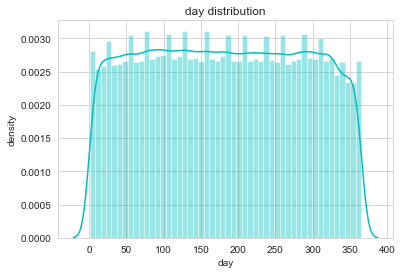

In [273]:
train_features['day'].plot_pdf()

In [274]:
print('The distribution in days is pretty flat. has only minor skew s = {}'.format(train_features['day'].series.skew()))


The distribution in days is pretty flat. has only minor skew s = 0.01044502861126917


We don't need to transform day


In [275]:
train_features_d['day'] = Feature(X_train,'day')
test_features_d['day'] = Feature(X_test,'day')

###### Engineering day of week feature

In [276]:
def get_day_number(first_day_of_year, day):
    # day number (0 for monday, 6 for sunday) for day
    return (first_day_of_year + day - 1) % 7

In [277]:
day_of_week_train = np.array([])
for index, row in tqdm(X_train.iterrows()):
    # For each data-point, we consider its year and day 
    # and calculate what day of the week (Monday, Tuesday, etc)
    # it was when the transaction happened
    # datetime.datetime(year, 1, 1).weekday() returns the first day of the year
    # using this information, we can calculate the present day

    year_i, day_i = row['year'], row['day']
    day_of_week_train = np.append(day_of_week_train, \
                                  get_day_number(datetime.datetime(year_i, 1, 1).weekday(), day_i))

0it [00:00, ?it/s]

In [278]:
day_of_week_test = np.array([])
for index, row in tqdm(X_test.iterrows()):
    #same as above but for test set

    year_i, day_i = row['year'], row['day']
    day_of_week_test = np.append(day_of_week_test, \
                                 get_day_number(datetime.datetime(year_i, 1, 1).weekday(), day_i))

0it [00:00, ?it/s]

In [280]:
train_features_d['day_of_week'] = Feature(pd.DataFrame(day_of_week_train.astype(int),columns=['day_of_week']),'day_of_week')
test_features_d['day_of_week'] = Feature(pd.DataFrame(day_of_week_test.astype(int),columns=['day_of_week']),'day_of_week')

####  2.1.2 length [bc_length]

In [283]:
train_features['length'].series.describe()

count    561463.000000
mean         44.950267
std          58.946800
min           0.000000
25%           2.000000
50%           8.000000
75%         108.000000
max         144.000000
Name: length, dtype: float64

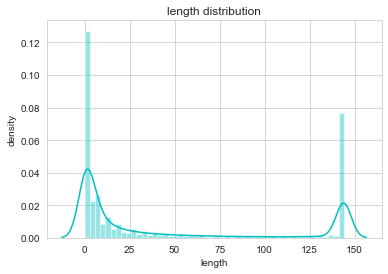

In [282]:
train_features['length'].plot_pdf()

In [464]:
train_features['length'].series.value_counts(bins=2)

(-0.145, 72.0]    406526
(72.0, 144.0]     154937
Name: length, dtype: int64

In [475]:
shapiro(train_features['length'].series)

ShapiroResult(statistic=0.6907636523246765, pvalue=0.0)

This has the form of a bimodal distribution according to the Shapiro test (p<0.05 we )


In [128]:
dft[dft['label']!='white'].groupby('label')['length'].describe()

count        mean         std    min    25%    50%  \
label                                                                      
APT                     1.0    2.000000         NaN    2.0    2.0    2.0   
Cerber               1083.0   42.035088   57.243543    0.0    2.0    8.0   
CryptConsole            2.0   72.000000  101.823376    0.0   36.0   72.0   
CryptXXX              293.0   48.648464   58.101493    0.0    2.0   16.0   
CryptoLocker         1144.0   30.968531   50.384965    0.0    0.0    6.0   
CryptoTorLocker2015     5.0   32.400000   62.424354    2.0    4.0    4.0   
CryptoWall           1476.0   48.891599   62.199693    0.0    2.0    8.0   
DMALocker              26.0   19.384615   46.150256    0.0    0.0    2.0   
DMALockerv3            51.0   44.666667   63.618446    0.0    0.0    4.0   
EDA2                    1.0  144.000000         NaN  144.0  144.0  144.0   
Flyper                  1.0   14.000000         NaN   14.0   14.0   14.0   
Globe                   7.0   43.714286   68.599597    0.0    1.0    6.0   
GlobeImposter           5.0   33.600000   62.119240    0.0    2.0    4.0   
JigSaw                  1.0    0.000000         NaN    0.0    0.0    0.0   
Locky                 785.0   47.329936   61.892966    0.0    2.0    8.0   
NoobCrypt              45.0   26.844444   55.193031    0.0    0.0    0.0   
Razy                    1.0   54.000000         NaN   54.0   54.0   54.0   
Sam                     1.0    6.000000         NaN    6.0    6.0    6.0   
SamSam                 11.0   43.454545   64.851158    0.0    0.0    8.0   
VenusLocker             2.0    8.000000    2.828427    6.0    7.0    8.0   
WannaCry                2.0  144.000000    0.000000  144.0  144.0  144.0   
XLocker                 1.0  144.000000         NaN  144.0  144.0  144.0   

                       75%    max  
label                              
APT                    2.0    2.0  
Cerber                72.0  144.0  
CryptConsole         108.0  144.0  
CryptXXX             102.0  144.0  
CryptoLocker          28.0  144.0  
CryptoTorLocker2015    8.0  144.0  
CryptoWall           144.0  144.0  
DMALocker              6.0  144.0  
DMALockerv3          144.0  144.0  
EDA2                 144.0  144.0  
Flyper                14.0   14.0  
Globe                 77.0  144.0  
GlobeImposter         18.0  144.0  
JigSaw                 0.0    0.0  
Locky                144.0  144.0  
NoobCrypt              8.0  144.0  
Razy                  54.0   54.0  
Sam                    6.0    6.0  
SamSam                81.0  144.0  
VenusLocker            9.0   10.0  
WannaCry             144.0  144.0  
XLocker              144.0  144.0

['address',
 'year',
 'day',
 'length',
 'weight',
 'count',
 'looped',
 'neighbors',
 'income']

length                                                       weight  \
          count       mean        std  min  25%  50%    75%    max     count   
label                                                                          
white  345060.0  44.947992  58.935955  0.0  2.0  8.0  106.0  144.0  345060.0   

                 ... neighbors             income                              \
           mean  ...       75%      max     count          mean           std   
label            ...                                                            
white  0.546767  ...       2.0  12920.0  345060.0  4.323266e+09  1.557013e+11   

                                                                        
              min          25%          50%          75%           max  
label                                                                   
white  30000000.0  73504278.25  200000000.0  999950000.0  4.966515e+13  

[1 rows x 40 columns]

In [130]:
dft[dft['label']!='white'].groupby('label')['length'].median()

label
APT                      2.0
Cerber                   8.0
CryptConsole            72.0
CryptXXX                16.0
CryptoLocker             6.0
CryptoTorLocker2015      4.0
CryptoWall               8.0
DMALocker                2.0
DMALockerv3              4.0
EDA2                   144.0
Flyper                  14.0
Globe                    6.0
GlobeImposter            4.0
JigSaw                   0.0
Locky                    8.0
NoobCrypt                0.0
Razy                    54.0
Sam                      6.0
SamSam                   8.0
VenusLocker              8.0
WannaCry               144.0
XLocker                144.0
Name: length, dtype: float64

In [467]:
dfc[dfc['label'] != 'white'].groupby('label')['length'].describe()['mean'].mean()

49.904383033479796

In [305]:
train_features['length'].skew # check how symmetric the pdf is

0.926722338090165

In [76]:
# check whether log and sqrt help the skew
X_tra_v = train_features['length'].vec
opsXa = np.log(np.sqrt(X_tra_v + 1e-6))
train_features['length'].skew, np.sqrt(X_train['length']).skew(), pd.Series(opsXa).skew()


(0.9301063947466278, 0.5786997644611137, -1.0686297218222065)

In [306]:
#constructing the feature
bc_length_train = boxcox((np.sin(np.log(np.sqrt(np.array(X_train['length']) + 1e-6))))**2)[0]
bc_length_test  = boxcox((np.sin(np.log(np.sqrt(np.array(X_test['length']) + 1e-6))))**2)[0]

In [307]:
# new features
train_features_d['bc_length'] = Feature(pd.DataFrame(bc_length_train, columns=['bc_length']),'bc_length')
test_features_d['bc_length'] = Feature(pd.DataFrame(bc_length_test, columns=['bc_length']),'bc_length')

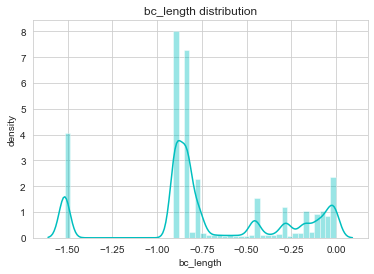

In [309]:
train_features_d['bc_length'].plot_pdf()

In [310]:
train_features_d['bc_length'].skew # the skew has improved but it's now biased

-0.03206929862926806

#### 2.1.3 weight [yeo_weight]

In [312]:
train_features['weight'].series.describe()

count    5.614630e+05
mean     5.462778e-01
std      4.606104e+00
min      3.606469e-94
25%      2.183655e-02
50%      2.500000e-01
75%      8.833250e-01
max      1.943749e+03
Name: weight, dtype: float64

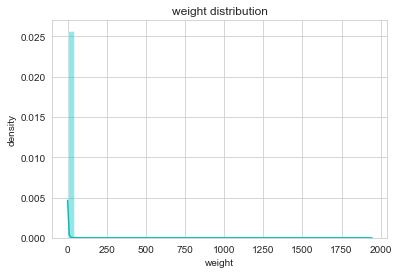

In [313]:
train_features['weight'].plot_pdf()

In [314]:
train_features['weight'].skew # very skewed!

280.4573588750912

In [321]:
train_features_d['yeo_weight'] = Feature( pd.DataFrame(train_features['weight'].yeo(),
                    columns=['yeo_weight']),'yeo_weight' )
test_features_d['yeo_weight'] = Feature( pd.DataFrame(test_features['weight'].yeo(),
                    columns=['yeo_weight']),'yeo_weight' )

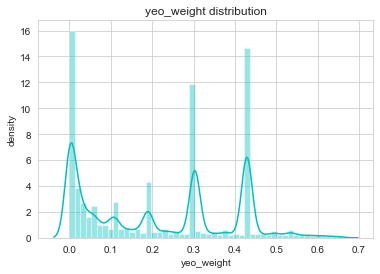

In [322]:
train_features_d['yeo_weight'].plot_pdf()

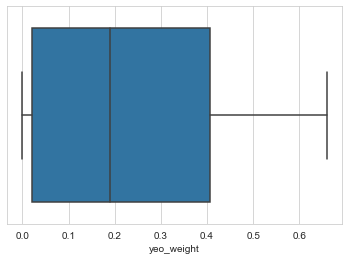

In [323]:
#plotting box plots
ax = plot_box(train_features_d['yeo_weight'].series)

#sns.boxplot(x=yeo_weight_train_ft.series)

In [324]:
train_features_d['yeo_weight'].skew

0.23440638184372953

#### 2.1.4 address [logbc_n_address]

In [325]:
train_features_d['address'] = Feature(X_train,'address')
test_features_d ['address'] = Feature(X_test, 'address')


In [326]:
X_train_address_ft = Feature(X_train,'address')
X_test_address_ft  = Feature(X_test,'address')

In [327]:
X_train['address'].value_counts()

1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU    76
16cVG72goMe4sNqZhnpmnqfCMZ1uSFbUit    60
12wQZTDmA8onM3sEt4jwcvzDxnNXxD8Vza    40
1LEq4WmpCrqBd7V3PywE2nvFUFC3QTe52x    38
1CVWpTNwNYGdKgZRohiiVFrnFNbw8anG9     35
                                      ..
3PRnPsknHbyxh7bmEz2JExAsnxjvHHr3mU     1
1KhDd3kCtYCg8Kjrn6Tw9hRPDr8fYoiAfq     1
1PD5cXpyNwL8SKYzcUWBEKgwVS8TPBubRQ     1
1ChWuXBqD1RDhrxA8nXv3K3ppoxt5A9GhM     1
1KasizAg9PNALw6hUZy7WKgkUcaf9DghbV     1
Name: address, Length: 533512, dtype: int64

##### Highest paid ransom address

In [343]:
print('the highest income address is')
dfc[dfc.label != 'white'][['income','address']].sort_values(by='income',ascending=False).head(1)['address']

the highest income address is


2412    135N2nfAkextd6E25quXpM98qLSi2BccCb
Name: address, dtype: object

In [344]:
df.address.value_counts()

1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU    101
16cVG72goMe4sNqZhnpmnqfCMZ1uSFbUit     75
12wQZTDmA8onM3sEt4jwcvzDxnNXxD8Vza     51
1LEq4WmpCrqBd7V3PywE2nvFUFC3QTe52x     49
12YursV58dRT2c9iuZg3jEWfwgTDamBcnd     48
                                     ... 
19EfypD1dG3mPM6eKj57H5SE4jbrsPUz9C      1
19wa2zFox8paunHem7mcYeZpPTdVGUQM7y      1
32Y3DcSYvXM1gHjcEZ2NirnFhrgMNDqqE4      1
1AN31sEsyHVTqXzqWvaWMMNcYMBiAWDArD      1
123wREowXiDjyoxkYymp7yapFmZu2zdT3d      1
Name: address, Length: 687847, dtype: int64

In [333]:
df[df['address']=='1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU'].label

34381    CryptoLocker
34315    CryptoLocker
34298    CryptoLocker
34239    CryptoLocker
33971    CryptoLocker
             ...     
34008    CryptoLocker
34188    CryptoLocker
34157    CryptoLocker
34154    CryptoLocker
34161    CryptoLocker
Name: label, Length: 101, dtype: object

In [328]:
worst_culprit_address = df[df['address']=='1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU']
worst_culprit_address[worst_culprit_address['year']==2013].describe()

year         day      length     weight        count  looped  \
count    62.0   62.000000   62.000000  62.000000    62.000000    62.0   
mean   2013.0  245.322581   10.032258   1.351558    70.483871     0.0   
std       0.0   79.087786   31.048332   0.679452   343.929784     0.0   
min    2013.0   92.000000    0.000000   0.000096     1.000000     0.0   
25%    2013.0  178.750000    0.000000   1.000000     1.000000     0.0   
50%    2013.0  253.500000    2.000000   1.000000     2.000000     0.0   
75%    2013.0  311.500000    4.000000   1.500000     3.000000     0.0   
max    2013.0  365.000000  144.000000   3.312269  2319.000000     0.0   

       neighbors        income  
count  62.000000  6.200000e+01  
mean    1.451613  6.696082e+09  
std     0.693705  2.129775e+10  
min     1.000000  1.655000e+08  
25%     1.000000  1.748748e+09  
50%     1.000000  3.019705e+09  
75%     2.000000  4.891061e+09  
max     4.000000  1.687649e+11

In [329]:
worst_culprit_address = df[df['address']=='1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU']
worst_culprit_address[worst_culprit_address['year']==2014].describe()

year         day      length     weight      count     looped  \
count    39.0   39.000000   39.000000  39.000000  39.000000  39.000000   
mean   2014.0   81.153846    3.435897   1.282052   1.717949   0.051282   
std       0.0   50.954850   17.561613   0.519929   0.856821   0.320256   
min    2014.0    5.000000    0.000000   0.500000   1.000000   0.000000   
25%    2014.0   38.500000    0.000000   1.000000   1.000000   0.000000   
50%    2014.0   74.000000    0.000000   1.000000   1.000000   0.000000   
75%    2014.0  122.000000    1.000000   1.500000   2.000000   0.000000   
max    2014.0  173.000000  110.000000   2.500000   4.000000   2.000000   

       neighbors        income  
count  39.000000  3.900000e+01  
mean    1.717949  1.764748e+09  
std     0.856821  3.581429e+09  
min     1.000000  4.076000e+07  
25%     1.000000  2.127200e+08  
50%     1.000000  6.354000e+08  
75%     2.000000  1.555902e+09  
max     4.000000  2.107868e+10

In [330]:
worst_culprit_address[['length','year','day']].groupby('year')['length'].var()

year
2013    963.998942
2014    308.410256
Name: length, dtype: float64

##### Feature engineering:  logbc_n_address_train
* the number of times the address appears (log boxcox transformation applied)

In [345]:
address_cnts = train_features_d['address'].series.value_counts()
print('An address is repeated an average of {:.3f} number of times'.format(np.mean(address_cnts)))

An address is repeated an average of 1.052 number of times


In [346]:
address_cnts.skew()

27.97646128250812

In [347]:
#Since this is an extremely skewed feature let's only visualize the 1st percentile points
one_percentile = np.percentile(address_cnts, 99)
n_addresses_1perc = np.array([element for element in address_cnts if element <= one_percentile])

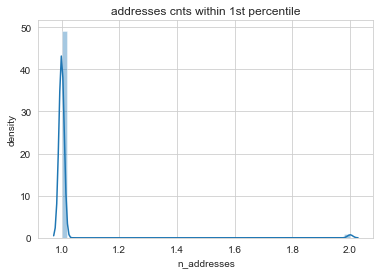

In [348]:
#checking points only within 1st percentile
plt.title('addresses cnts within 1st percentile')
sns.distplot(n_addresses_1perc)
plt.xlabel('n_addresses')
plt.ylabel('density')
plt.show()

In [349]:
dict_address_cnts = dict(X_train['address'].value_counts())
n_address = boxcox(np.array(list(dict_address_cnts.values())))[0]
# 
for index, key in tqdm(enumerate(dict_address_cnts.keys())):
    # updating the dictionary with number of times each address appears with the boxcox transformation applied to fix the skewness
    dict_address_cnts.update({key: address_cnts[index]})
 

0it [00:00, ?it/s]

In [350]:
n_address.min()

0.0

In [351]:
bc_address_n = boxcox(np.array(list(dict_address_cnts.values())))[0] # 
pd.Series(bc_address_n).skew()

5.953107169677995

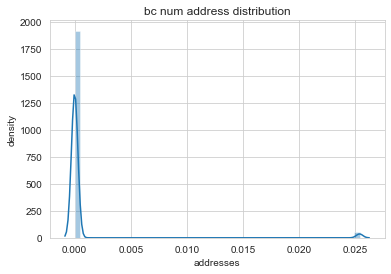

In [352]:
#plot to print distribution of n_addresses
plt.title('bc num address distribution')
sns.distplot(bc_address_n)
plt.xlabel('addresses')
plt.ylabel('density')
plt.show()

In [353]:
bc_n_address_train = np.array([])

for index, row in tqdm(X_train.iterrows(), total=X_train.shape[0]):
    # For each address in the training set append the boxcox'd
    # number of times it appears in the training set

    n_address_i = dict_address_cnts.get(X_train.loc[index]['address'])
    
    bc_n_address_train = np.append(bc_n_address_train, n_address_i)

bc_n_address_test = np.array([])
min_dict_n_address = min(list(dict_address_cnts.values()))

for index, row in tqdm(X_test.iterrows(), total=X_test.shape[0]):
    # For each address in the training set append the boxcox'd
    # number of times it appears in the training set
    try:
        #we do the same as above
        n_address_i = dict_address_cnts[X_test.loc[index]['address']]
    except KeyError:
        #KeyError arises when the addreses in training set has not been seen before (i.e cold start)
        #For this, we assign the minimum value to it

        n_address_i = min_dict_n_address #Addressing cold start
    bc_n_address_test = np.append(bc_n_address_test, n_address_i)

  0%|          | 0/561463 [00:00<?, ?it/s]

  0%|          | 0/167711 [00:00<?, ?it/s]

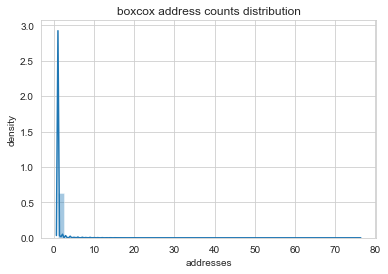

In [354]:
plt.title('boxcox address counts distribution')
sns.distplot(bc_n_address_train)
plt.xlabel('addresses')
plt.ylabel('density')
plt.show()

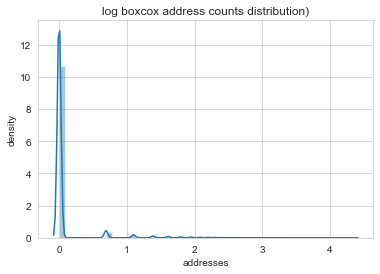

In [355]:
plt.title('log boxcox address counts distribution)')
sns.distplot(np.log(bc_n_address_train)) 
plt.xlabel('addresses')
plt.ylabel('density')
plt.show()

In [356]:
logbc_n_address_train = np.log(bc_n_address_train)
logbc_n_address_test = np.log(bc_n_address_test)

In [357]:
train_features_d['logbc_n_address'] = Feature( pd.DataFrame(logbc_n_address_train,
                    columns=['logbc_n_address']),'logbc_n_address' )
test_features_d['logbc_n_address']  = Feature( pd.DataFrame(logbc_n_address_test,
                    columns=['logbc_n_address']),'logbc_n_address' )

In [358]:
train_features_d['logbc_n_address'].skew

4.734594416456778

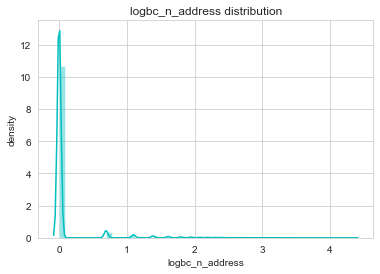

In [359]:
train_features_d['logbc_n_address'].plot_pdf()

#### 2.1.5 neighbors [bc_neighbors]

In [369]:
train_features['neighbors'].series.describe()

count    561463.000000
mean          2.222531
std          23.915774
min           1.000000
25%           1.000000
50%           2.000000
75%           2.000000
max       12920.000000
Name: neighbors, dtype: float64

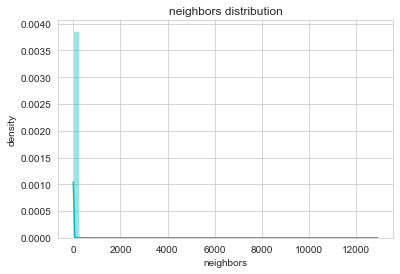

In [370]:
train_features['neighbors'].plot_pdf()

In [371]:
train_features['neighbors'].skew

349.670288068549

In [372]:
# apply boxcox
bc_neighbors_train = train_features['neighbors'].bc()
bc_neighbors_test = test_features['neighbors'].bc()

In [373]:
# generate new feature
train_features_d['bc_neighbors'] = Feature(pd.DataFrame(bc_neighbors_train,
                    columns=['bc_neighbors']),'bc_neighbors')
test_features_d['bc_neighbors'] = Feature( pd.DataFrame(bc_neighbors_test,
                    columns=['bc_neighbors']),'bc_neighbors')

In [374]:
train_features_d['bc_neighbors'].mean# skew is reduced

0.43092982180546063

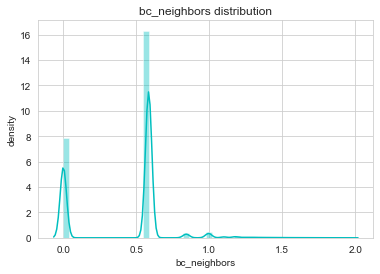

In [375]:
train_features_d['bc_neighbors'].plot_pdf()

In [376]:

dfc[dfc['label'] != 'white'].groupby('label')['neighbors'].describe()

count       mean        std  min    25%   50%    75%  \
label                                                                        
APT                     2.0   2.500000   0.707107  2.0   2.25   2.5   2.75   
Cerber               2209.0   2.014939   0.406306  1.0   2.00   2.0   2.00   
CryptConsole            3.0   2.000000   0.000000  2.0   2.00   2.0   2.00   
CryptXXX              617.0   1.972447   0.655312  1.0   2.00   2.0   2.00   
CryptoLocker         2322.0   2.883290   3.439348  1.0   2.00   2.0   3.00   
CryptoTorLocker2015    10.0   7.000000   5.517648  2.0   2.00   5.5  10.50   
CryptoWall           3008.0   1.942819   2.130289  1.0   1.00   1.0   2.00   
DMALocker              50.0   1.880000   1.349830  1.0   1.00   1.0   2.00   
DMALockerv3            93.0   1.161290   0.576540  1.0   1.00   1.0   1.00   
EDA2                    1.0   2.000000        NaN  2.0   2.00   2.0   2.00   
Flyper                  2.0   1.500000   0.707107  1.0   1.25   1.5   1.75   
Globe                  11.0   2.181818   0.750757  1.0   2.00   2.0   2.00   
GlobeImposter           9.0   2.555556   2.743680  1.0   1.00   1.0   2.00   
Globev3                 4.0   1.750000   0.500000  1.0   1.75   2.0   2.00   
JigSaw                  2.0   2.000000   0.000000  2.0   2.00   2.0   2.00   
Locky                1628.0   1.238329   0.458163  1.0   1.00   1.0   1.00   
NoobCrypt             101.0   1.227723   0.719461  1.0   1.00   1.0   1.00   
Razy                    3.0  19.333333  15.947832  1.0  14.00  27.0  28.50   
Sam                     1.0   3.000000        NaN  3.0   3.00   3.0   3.00   
SamSam                 16.0   1.500000   0.894427  1.0   1.00   1.0   2.00   
VenusLocker             3.0   1.666667   0.577350  1.0   1.50   2.0   2.00   
WannaCry                6.0   1.333333   0.816497  1.0   1.00   1.0   1.00   
XLocker                 1.0   1.000000        NaN  1.0   1.00   1.0   1.00   
XLockerv5.0             2.0   1.500000   0.707107  1.0   1.25   1.5   1.75   
XTPLocker               3.0   1.000000   0.000000  1.0   1.00   1.0   1.00   

                      max  
label                      
APT                   3.0  
Cerber               10.0  
CryptConsole          2.0  
CryptXXX              6.0  
CryptoLocker         63.0  
CryptoTorLocker2015  16.0  
CryptoWall           37.0  
DMALocker             6.0  
DMALockerv3           5.0  
EDA2                  2.0  
Flyper                2.0  
Globe                 4.0  
GlobeImposter         9.0  
Globev3               2.0  
JigSaw                2.0  
Locky                 6.0  
NoobCrypt             7.0  
Razy                 30.0  
Sam                   3.0  
SamSam                4.0  
VenusLocker           2.0  
WannaCry              3.0  
XLocker               1.0  
XLockerv5.0           2.0  
XTPLocker             1.0

In [377]:

dfc[dfc['label'] == 'white'].groupby('label')['neighbors'].describe()

count      mean       std  min  25%  50%  75%      max
label                                                           
white  719067.0  2.216711  22.39515  1.0  1.0  2.0  2.0  12920.0

#### 2.1.6 looped  [sig_looped]

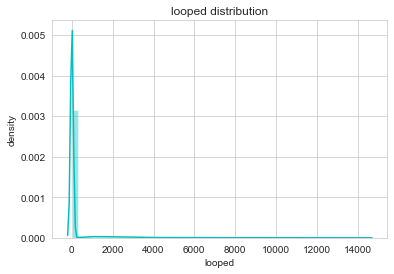

In [378]:
train_features['looped'].plot_pdf()

In [379]:
train_features['looped'].skew

5.544117274510451

In [380]:
# apply sigmoid
sig_looped_train = train_features['looped'].sigmoid()
sig_looped_test  = test_features['looped'].sigmoid()

In [381]:
# generate new feature
train_features_d['sig_looped'] = Feature(pd.DataFrame(sig_looped_train,
                    columns=['sig_looped']),'sig_looped' )
test_features_d['sig_looped'] = Feature(pd.DataFrame(sig_looped_test,
                    columns=['sig_looped']),'sig_looped' )

In [382]:
train_features_d['sig_looped'].skew

2.2215463159882374

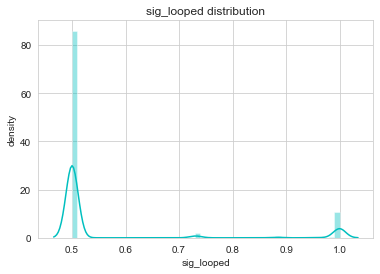

In [383]:
train_features_d['sig_looped'].plot_pdf()

#### 2.1.7 count [log_count]

In [384]:
#X_train_cnt_ft = feature(X_train,'count')
#X_test_cnt_ft  = feature(X_test,'count')

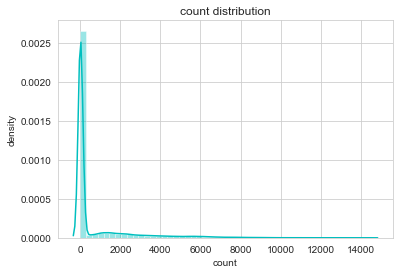

In [385]:
train_features['count'].plot_pdf()

In [386]:
train_features['count'].skew

2.9361537332298413

In [387]:
min(train_features['count'].vec)

1

In [388]:
log_count_train = np.log(train_features['count'].vec)
log_count_test  = np.log(test_features['count'].vec)

In [389]:
# generate new feature
train_features_d['log_count'] = Feature(pd.DataFrame(log_count_train,
                    columns=['log_count']),'log_count')
test_features_d['log_count'] = Feature(pd.DataFrame(log_count_test,
                    columns=['log_count']),'log_count')

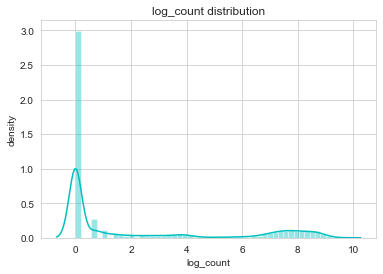

In [390]:
train_features_d['log_count'].plot_pdf()

In [391]:
train_features_d['log_count'].skew

1.0654651240037887

# 3.0 Standardizing and Encoding

In [392]:
list(train_features_d.keys())

['year',
 'bc_income',
 'day',
 'day_of_week',
 'bc_length',
 'yeo_weight',
 'address',
 'logbc_n_address',
 'bc_neighbors',
 'sig_looped',
 'log_count']

In [393]:
# original columns to get scaled for distance based classifiers
cols_orig = [ 
    'year',
    'day',
    'length',
    'weight',
    'count',
    'looped',
    'neighbors',
    'income']
# new columns to get scaled for distance based classifiers
cols_new = [
    'address',
    'bc_income',
    'bc_length',
    'yeo_weight',
    'logbc_n_address',
    'bc_neighbors',
    'sig_looped',
    'log_count',
    'year',
    'day',
    'day_of_week'
]

cols = cols_orig + cols_new
num_to_enc = 1

In [394]:
X_train_d = pd.DataFrame()
X_test_d = pd.DataFrame()

In [395]:
train_features_d

{'year': <__main__.Feature at 0x29cd8f730>,
 'bc_income': <__main__.Feature at 0x2add7b820>,
 'day': <__main__.Feature at 0x2adf09df0>,
 'day_of_week': <__main__.Feature at 0x2ade72460>,
 'bc_length': <__main__.Feature at 0x2bc49db50>,
 'yeo_weight': <__main__.Feature at 0x13af39b50>,
 'address': <__main__.Feature at 0x13ae6cdf0>,
 'logbc_n_address': <__main__.Feature at 0x3137c68b0>,
 'bc_neighbors': <__main__.Feature at 0x313c64610>,
 'sig_looped': <__main__.Feature at 0x313dece20>,
 'log_count': <__main__.Feature at 0x313d62f10>}

In [396]:
X_train_d['address']=train_features['address'].vec

In [397]:
for col in cols_new:
    X_train_d[col] = train_features_d[col].vec
    X_test_d[col] = test_features_d[col].vec


In [398]:
if SAVE_TEST_TRAIN == True:
    with open('derived'+fname, 'wb') as save_file:
        pickle.dump([X_train, y_train, X_test, y_test], save_file)

#### 3.1.0 Scaling and encoding the data

In [399]:
# cols to standardize (0 mean, unit variance)
col_names_standardize = ['bc_income',
                         'bc_length',
                         'yeo_weight',
                         'logbc_n_address',
                         'bc_neighbors',
                         'sig_looped',
                         'log_count']
# cols to encode
col_names_encode = ['day_of_week']
col_names_pass = ['year','address', 'day']

In [400]:
X_train_d

address  bc_income  bc_length  yeo_weight  \
0       152PVs5BJXc6ffpnTfodo8gk4459ga2rGo   4.118361  -0.835123    0.002122   
1       3HsKgPcBZX8LhzAZLbY5yEAvSeJVhe1hyp   4.125074  -1.517506    0.189317   
2       1BBiuoy7bYaaMkCQNw9TJaM829PrAvML4o   4.106015  -0.063107    0.107866   
3        1vTKvyRX2JUHJc37vjMjiG5q9qmuPBfsG   4.133130  -0.000639    0.428972   
4       12aPhUHp4MVEPc94SsoASkEeJXnZmK8sHZ   4.118753  -0.063107    0.003887   
...                                    ...        ...        ...         ...   
561458  3F2ndcScfjb3qQUGer3AEFCRgiPdVctJ3K   4.126515  -0.835123    0.499521   
561459  3DY52Fau1HC1zK2TU7ShyzVqVKhhhTEHvs   4.142881  -0.475318    0.000003   
561460  1HN2ijH7JECUkwvmGHZWmApfZEm3KP1SRh   4.138220  -0.107729    0.007736   
561461  1Km6v9iejV2Dv5Q1WcD8NfxQuekqNv1brC   4.126054  -0.454637    0.222847   
561462  1KasizAg9PNALw6hUZy7WKgkUcaf9DghbV   4.139552  -0.835123    0.262896   

        logbc_n_address  bc_neighbors  sig_looped  log_count  year  day  \
0              1.098612      0.000000         0.5   6.463029  2014  264   
1              0.000000      0.000000         0.5   0.000000  2016  195   
2              0.000000      0.584252         0.5   0.000000  2014  183   
3              0.000000      0.584252         0.5   0.000000  2014  202   
4              0.000000      0.000000         0.5   0.000000  2013    2   
...                 ...           ...         ...        ...   ...  ...   
561458         0.000000      0.584252         1.0   8.637107  2018  241   
561459         0.000000      0.584252         0.5   0.000000  2018  110   
561460         0.000000      0.000000         0.5   0.000000  2011  128   
561461         0.000000      0.584252         0.5   1.098612  2013  287   
561462         0.000000      0.584252         0.5   7.733684  2015   15   

        day_of_week  
0                 6  
1                 2  
2                 2  
3                 0  
4                 2  
...             ...  
561458            2  
561459            4  
561460            6  
561461            0  
561462            3  

[561463 rows x 11 columns]

In [401]:
X_train

address  year  day  length    weight  \
1389833  152PVs5BJXc6ffpnTfodo8gk4459ga2rGo  2014  264     144  0.002128   
2050983  3HsKgPcBZX8LhzAZLbY5yEAvSeJVhe1hyp  2016  195       2  0.250000   
1308993  1BBiuoy7bYaaMkCQNw9TJaM829PrAvML4o  2014  183      14  0.125000   
1327903   1vTKvyRX2JUHJc37vjMjiG5q9qmuPBfsG  2014  202      22  1.000000   
762993   12aPhUHp4MVEPc94SsoASkEeJXnZmK8sHZ  2013    2      14  0.003906   
...                                     ...   ...  ...     ...       ...   
2827069  3F2ndcScfjb3qQUGer3AEFCRgiPdVctJ3K  2018  241     144  1.544710   
2695959  3DY52Fau1HC1zK2TU7ShyzVqVKhhhTEHvs  2018  110      92  0.000003   
159013   1HN2ijH7JECUkwvmGHZWmApfZEm3KP1SRh  2011  128      12  0.007812   
1048336  1Km6v9iejV2Dv5Q1WcD8NfxQuekqNv1brC  2013  287       6  0.312500   
1505724  1KasizAg9PNALw6hUZy7WKgkUcaf9DghbV  2015   15     144  0.398461   

         count  looped  neighbors        income  
1389833    641       0          1  1.000000e+08  
2050983      1       0          1  1.818900e+08  
1308993      1       0          2  4.000000e+07  
1327903      1       0          2  4.270780e+08  
762993       1       0          1  1.033284e+08  
...        ...     ...        ...           ...  
2827069   5637    5625          2  2.093145e+08  
2695959      1       0          2  1.632521e+09  
159013       1       0          1  8.150000e+08  
1048336      3       0          2  2.000000e+08  
1505724   2284       0          2  9.825900e+08  

[561463 rows x 9 columns]

In [402]:
# transform the data for use in distance based modeling algorithms [logistic regression]
transformer = ColumnTransformer(
    [('standardize', StandardScaler(), col_names_standardize),
    ('encode', OneHotEncoder(dtype=int), col_names_encode)],
    remainder = 'passthrough',
     verbose_feature_names_out=False)

transformer.fit(X_train_d)

ColumnTransformer(remainder='passthrough',
                  transformers=[('standardize', StandardScaler(),
                                 ['bc_income', 'bc_length', 'yeo_weight',
                                  'logbc_n_address', 'bc_neighbors',
                                  'sig_looped', 'log_count']),
                                ('encode', OneHotEncoder(dtype=<class 'int'>),
                                 ['day_of_week'])],
                  verbose_feature_names_out=False)

In [403]:
# std. transformed and encoded variables (np arrays)
X_train_e = transformer.transform(X_train_d)
X_test_e  = transformer.transform(X_test_d)
# std. transformed and encoded variables (df with verbose headers)

X_train_e_df = pd.DataFrame(X_train_e,columns=transformer.get_feature_names_out())
X_test_e_df = pd.DataFrame(X_test_e,columns=transformer.get_feature_names_out())

In [404]:
if SAVE_TEST_TRAIN == True:
    with open('encoded'+fname, 'wb') as save_file:
        pickle.dump([X_train, y_train, X_test, y_test], save_file)


<AxesSubplot:xlabel='income', ylabel='neighbors'>

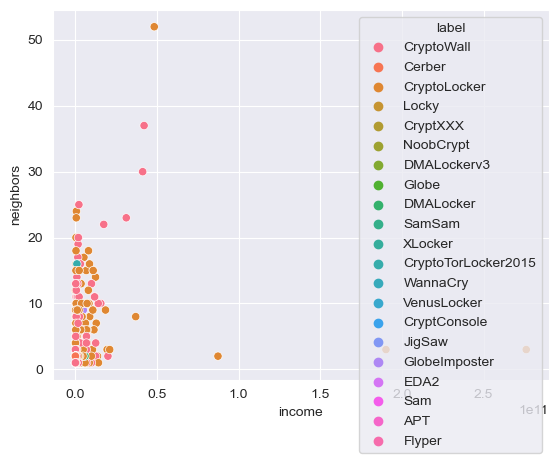

# 4.0 Resampling

In [405]:
print('Training set has {} rows and {} columns.'.format(X_train.shape[0], X_train.shape[1]))
print('Testing set has {} rows and {} columns.'.format(X_test.shape[0], X_test.shape[1]))
print('Training set has {} points that belong to postitive class (ransomware) and {} points that belong to negative class (white).'.format(
    sum(y_train['labels']),
    len(y_train['labels']) - sum(y_train['labels'])
))
print('Percentage of positive class data-points: {:.2f}%'.format((sum(y_train['labels'])/(len(y_train['labels'])) * 100)))

Training set has 561463 rows and 9 columns.
Testing set has 167711 rows and 9 columns.
Training set has 7782 points that belong to postitive class (ransomware) and 553681 points that belong to negative class (white).
Percentage of positive class data-points: 1.39%


## 4.1 Sampling

In [406]:
from imblearn.over_sampling import SMOTE


### 4.1.0 Downsampling

In [407]:
class Sampler:

    def __init__(self,X):
        self.X_df = pd.DataFrame(X)
        self.positive_df = pd.DataFrame([], columns = self.X_df.columns)
        self.negative_df = pd.DataFrame([], columns = self.X_df.columns)
        self.combined_df = pd.DataFrame([], columns = self.X_df.columns)
        self.X_train_sm =  pd.DataFrame([], columns = self.X_df.columns)
        self.y_train_sm =  pd.DataFrame([], columns = ['lables'])
        self.X_train_rus = pd.DataFrame([], columns = self.X_df.columns)
        self.y_train_rus =  pd.DataFrame([], columns = ['lables'])



    def up_samp_smote(self, X_train, y_train, ratio):
        """Upsamples minority class using SMOTE.
        Ratio argument is the percentage of the upsampled minority class in relation
        to the majority class.
        """
        sm = SMOTE(random_state=RAND_STATE, sampling_strategy=ratio)
        X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
        #print(len(X_train_sm), len(y_train_sm))
        self.X_train_sm, self.y_train_sm = X_train_sm, y_train_sm


    def down_samp_rand(self, X_train, y_train, ratio):
        """Downsamples majority class using random sampling.
        Ratio argument is the ratio of minority class to the downsampled majority
        """
        rus = RandomUnderSampler(sampling_strategy=ratio,random_state=RAND_STATE)
        X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
        self.X_train_rus, self.y_train_rus = X_train_rus, y_train_rus


    def down_samp(self, y_train, prob=0.015):
        index = 0

        for index_df, row in tqdm(self.X_df.iterrows(), total=self.X_df.shape[0]):
            if y_train[index] == 0:
                if np.random.uniform(0, 1) < prob:
                    #picking negative class with a probability=prob
                    self.negative_df = self.negative_df.append(row, ignore_index=True)
                    index += 1
                else:
                    index += 1
            elif y_train[index] == 1:
            #picking all positive data-points
                self.positive_df = self.positive_df.append(row, ignore_index=True)
                index += 1
        self.combined_df = self.positive_df.append(self.negative_df, ignore_index = True)

**e_ds** <n>
- Encoded, standard scaled, and normalized data.
- Split of X_train_e [standardized, encoded] without column headers.

In [408]:
X_train_e_df.drop(columns=['address'],axis=1,inplace=True)

In [409]:
# Create a sample object
e_ds = Sampler(X_train_e_df)

In [410]:
e_ds.down_samp_rand(X_train_e_df, y_train['labels'], 0.05) # downsample using random resampling

In [411]:
e_ds.up_samp_smote(e_ds.X_train_rus, e_ds.y_train_rus, 0.25) # upsampling using SMOTE

In [412]:
READ_STATE = False

# 5.0 Modeling

In [414]:
def plot_roc(model, X, y, plot_title):
    plot_roc_curve(model, X, y)
    plt.title(plot_title)
    plt.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), label='RandomModel (AUC = 0.50)')
    plt.legend()
    plt.show()


def confusion_mat(y, y_pred):
    cf_matrix = confusion_matrix(y, y_pred)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Reds')


def tabulate_scores_df(model_name, y_test, y_pred):
    df2 = pd.DataFrame([[
        model_name,
        accuracy_score(y_true=y_test, y_pred=y_pred),
        precision_score(y_true=y_test, y_pred=y_pred),
        recall_score(y_true=y_test, y_pred=y_pred),
        f1_score(y_true=y_test, y_pred=y_pred)]],
        columns=['Type', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])

    return df2


In [521]:
class Model:
    def __init__(self, x_tr, y_tr, X_tr, X_tst, routine, params, classifier, crss_vldtr=None):
        '''Model'''
        self.classifier = classifier
        self.X_tst = X_tst


        #  randomized search on hyper parameters
        search = RandomizedSearchCV(
            estimator = routine,
            param_distributions = params,
            scoring = 'accuracy',
            cv = crss_vldtr,
            n_jobs = -1,
            verbose = 1,
            random_state = RAND_STATE,
            return_train_score = True,
            n_iter = 5
        )
        if READ_STATE == True:
            tag = input('Enter head of parameter file to read')
            rf_hps_fname = tag + '_bestparams_sm_e_05.csv'
            print('reading file ', rf_hps_fname)
            bps = pd.read_csv(rf_hps_fname, index_col=False).to_dict('list')
            bps.pop('Unnamed: 0')
            ks = [k for k in bps.keys()]
            vs = [v[0] for v in bps.values()]
            self.best_params = dict( zip(ks,vs) )
        else:
            search.fit(x_tr, y_tr)
            self.best_params = search.best_params_

        print(self.best_params)
        tuned = classifier(**self.best_params,# n_jobs = -1,
                            random_state = RAND_STATE)
        self.tuned = tuned
        # fit
        tuned.fit(x_tr, y_tr)
        # predict
        self.preds_train = tuned.predict(X_tr)
        self.preds_test  = tuned.predict(X_tst)
        self.params      = tuned.get_params()

    def score(self,y_tr,y_tst):
        trn_score_df = tabulate_scores_df('trn', y_tr, self.preds_train)
        tst_score_df = tabulate_scores_df('tst', y_tst, self.preds_test)
        score_df = trn_score_df.append(tst_score_df)
        return score_df

    def roc(self, y_tst, title):
        plot_roc(self.tuned, self.X_tst,y_tst, title)

    def conf_mat(self, y_tr, y_tst):
        plt.figure(figsize=(15,7))

        plt.subplot(1,2,1) # first heatmap
        confusion_mat(y_tr, self.preds_train)

        plt.subplot(1,2,2) # first heatmap
        confusion_mat(y_test, self.preds_test)

        plt.show()

    def feature_imps(self,colnames):
        feat_ranks_df = pd.DataFrame(np.ravel(self.tuned.feature_importances_), index=colnames)
        feat_ranks_df.columns = ['feature importance']
        feat_ranks_df.sort_values(by='feature importance', ascending=False)
        return feat_ranks_df

In [417]:
from collections import Counter
counter = Counter(y_train['labels'])
estimate = np.sqrt(counter[0] / counter[1])

In [419]:
from sklearn.svm import LinearSVC

In [420]:
models = {
    "sgd": { "estimater": SGDClassifier(),
             "params": {
                 "loss" : [ "log_loss", "perceptron"],
                 "alpha" : [0.0001, 0.001, 0.01, 0.1],
                 "penalty" : ["l2", "l1", "elasticnet"],
                 "class_weight" : ['balanced', None],}
             },
    "rf": { "estimater": RandomForestClassifier(),
            "params": {
                'max_depth' : [2,5,10,15],
                'n_estimators' : [100, 500, 1000],
                "class_weight" : ['balanced', None],}
            },
    "xgb": {"estimater": XGBClassifier(),
            "params": {
                'n_estimators': stats.randint(150, 1000),
                'learning_rate': stats.uniform(0.01, 0.59),
                'subsample': stats.uniform(0.3, 0.6),
                'max_depth': [3, 4, 5, 6, 7],
                'colsample_bytree': stats.uniform(0.5, 0.4),
                'scale_pos_weight' : stats.uniform(estimate,estimate**2),
                'min_child_weight': [1, 2, 3, 4],}
            },
    "lsvc": { "estimater": LinearSVC(),
              "params": { }
              },
    "svc": { "estimater": SVC(),
             "params": {
                 'C': [0.1,1, 10, 100, 1000],
                 'gamma': [1,0.1,0.01,0.001,0.0001],
                 'kernel': ['rbf'],}
             }
}

In [421]:
X_test_e_df.drop(columns=['address'],axis=1,inplace=True)

In [422]:
# Create model
sgd_cl = SGDClassifier(random_state=RAND_STATE, max_iter=3000, learning_rate='optimal')
sgd_params_in = {
    "loss": ["log_loss", "perceptron"],
    "alpha": [0.0001, 0.001, 0.01, 0.1],
    "penalty": ["l2", "l1", "elasticnet"],
    "class_weight": ['balanced', None]
}
sgd = Model(
    e_ds.X_train_sm, e_ds.y_train_sm,
    X_train_e_df, X_test_e_df,
    sgd_cl, sgd_params_in, SGDClassifier)
sgd.params

Fitting 5 folds for each of 5 candidates, totalling 25 fits
{'penalty': 'l1', 'loss': 'perceptron', 'class_weight': 'balanced', 'alpha': 0.1}


{'alpha': 0.1,
 'average': False,
 'class_weight': 'balanced',
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.0,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'optimal',
 'loss': 'perceptron',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'n_jobs': None,
 'penalty': 'l1',
 'power_t': 0.5,
 'random_state': 42,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [423]:
sgd.score(y_train,y_test)

Type  Accuracy  Precision    Recall  F1-Score
0  trn  0.924273   0.084895  0.456438  0.143162
0  tst  0.952561   0.121012  0.386667  0.184335

Compare result to original features

In [ ]:
# Create model
sgd_cl0 = SGDClassifier(random_state=RAND_STATE, max_iter=4000, learning_rate='optimal',n_jobs=-1)
sgd_params_in = {
    "loss": [ "perceptron"],
    "alpha": [ 0.1],
    "penalty": ["l2", "l1", "elasticnet"],
    "class_weight": ['balanced', None]
}
sgd0 = Model(
    X_train.drop(labels=['address'],axis=1), y_train['labels'],
    X_train.drop(labels=['address'],axis=1), X_test.drop(labels=['address'],axis=1),
    sgd_cl0, sgd_params_in, SGDClassifier)
sgd0.params

KeyboardInterrupt: 

In [520]:
sgd0.score(y_train,y_test)

Type  Accuracy  Precision  Recall  F1-Score
0  trn  0.013860   0.013860     1.0  0.027341
0  tst  0.013863   0.013863     1.0  0.027347